# Single channgel receiver example

In [2]:
! bladeRF-cli -p


  Description:    Nuand bladeRF 2.0
  Backend:        libusb
  Serial:         eb56038a9b0d4ccdace93a3476002277
  USB Bus:        2
  USB Address:    3



In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (16, 8)

In [4]:
import numpy as np
from numpy.fft import fft, fftshift, fftfreq

In [5]:
import pyblade

In [28]:
rx_config = pyblade.RxConfig(
    samplerate='4M',
    frequency=433e6,
    bandwidth='2M',
    n_samples='1M',
    agc=None,  # disable AGC
    channels=(1, ),  # read from channel 1
)

In [29]:
rx_config

RxConfig(samplerate='4M', frequency=433000000.0, bandwidth='2M', channels=(1,), n_samples='1M', agc=None)

In [54]:
iq = pyblade.run(
    rx_config=rx_config,
    scenario=('rx start',
              'rx',
              'rx wait')
)

In [55]:
iq.shape

(1, 1048576)

In [56]:
x_t = iq[0, ]
x_t.shape

(1048576,)

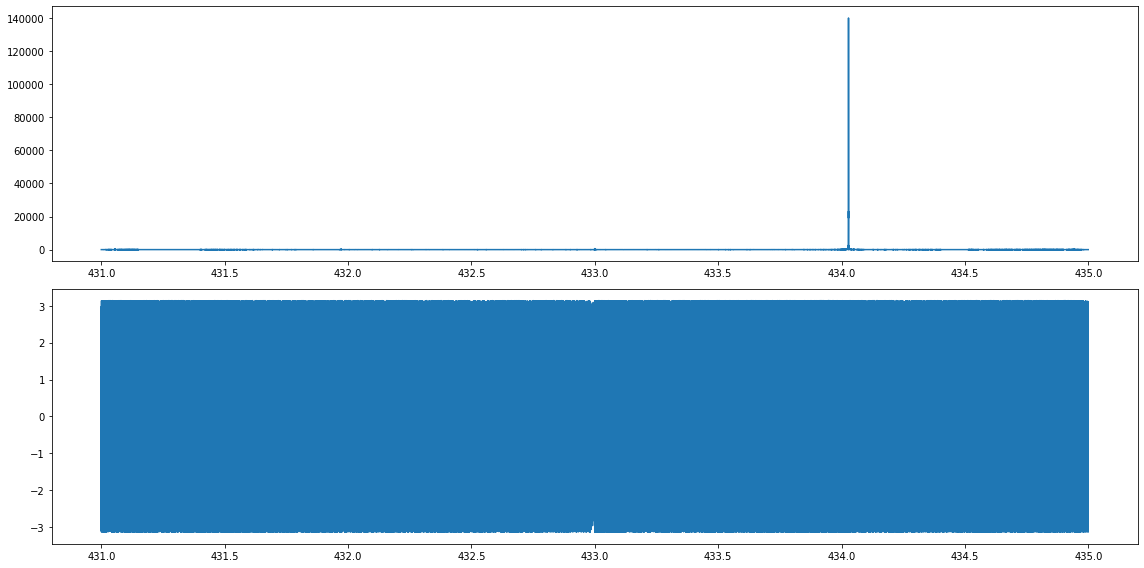

In [57]:
t_s = 1. / rx_config.samplerate_

f = (fftfreq(len(x_t), d=t_s) + rx_config.frequency_) * 1e-6
f = fftshift(f)

x_f = fft(x_t)
x_f = fftshift(x_f)

fig, (axis_mag, axis_phi) = plt.subplots(nrows=2)

axis_mag.plot(f, np.abs(x_f))
axis_phi.plot(f, np.angle(x_f))

fig.tight_layout()

In [62]:
windows_length = 1024
window_overlap = 0.2

# NOTE: sliding_window_view is numpy view
#  (see https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html)
#  and requres no additional memory, it can only stride with a single element but combining it with 
#  additional skipping view a custom stride is made:
stride = int(windows_length * (1 - window_overlap))
w_t = np.lib.stride_tricks.sliding_window_view(x_t, windows_length)[::stride, ...]
w_t.shape

(1280, 1024)

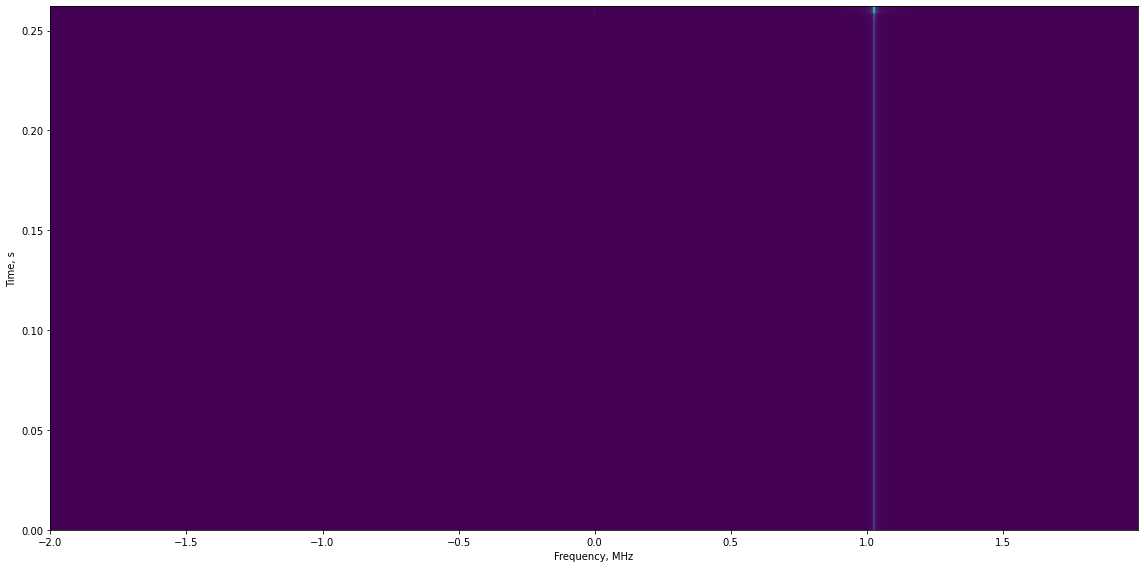

In [64]:
n_fft = 1024

f = (fftfreq(n_fft, d=t_s)) * 1e-6
f = fftshift(f)

w_f = fft(w_t, axis=1, n=n_fft)

w_f = fftshift(w_f, axes=1)

fig, axis_spectrogram = plt.subplots(nrows=1)

axis_spectrogram.imshow(np.abs(w_f), cmap='viridis', aspect='auto', extent=[
    f[0], 
    f[-1],
    0, 
    t_s * w_f.shape[0] * stride # the beginning of the last window
], )
axis_spectrogram.set_xlabel('Frequency, MHz')
axis_spectrogram.set_ylabel('Time, s')

# axis_spectrogram.set_xlim(.8, 1)
fig.tight_layout()